# Part 2: Spatial Interaction models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#read in your London Commuting Data
cdata = pd.read_csv("https://raw.githubusercontent.com/kav-sekar/us_london_network/main/london_flows.csv")
cdata.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [3]:
origPop = cdata.groupby(by="station_origin", as_index=False).mean()
origPop.drop(columns=['flows','jobs','distance'], inplace= True)
origPop.head()

,station_origin,population
0,Abbey Road,599.0
1,Acton Central,1224.0
2,Acton Town,3745.0
3,Aldgate,2886.0
4,Aldgate East,3172.0


In [4]:
destJob = cdata.groupby(by="station_destination", as_index=False).mean()
destJob.drop(columns=['flows','population','distance'], inplace= True)
destJob.head()

,station_destination,jobs
0,Abbey Road,345.0
1,Acton Central,750.0
2,Acton Town,2202.0
3,Aldgate,7782.0
4,Aldgate East,7932.0


In [5]:
popJob = origPop.merge(destJob, left_on = "station_origin", right_on ="station_destination")
popJob.drop(columns = 'station_destination', inplace = True)
popJob.rename(columns = {'station_origin':'Orig'}, inplace = True)
popJob.head()

,Orig,population,jobs
0,Abbey Road,599.0,345.0
1,Acton Central,1224.0,750.0
2,Acton Town,3745.0,2202.0
3,Aldgate,2886.0,7782.0
4,Aldgate East,3172.0,7932.0


In [6]:
#merge on the origins
cdata = cdata.merge(popJob, left_on = "station_origin", right_on ="Orig")
cdata.drop(columns = ["Orig"], inplace = True)
cdata.rename(columns={cdata.columns[-2]:"Oi1_origpop", cdata.columns[-1]: "Oi2_origjob"}, inplace = True)

cdata.head()

,station_origin,station_destination,flows,population_x,jobs_x,distance,Oi1_origpop,Oi2_origjob
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599.0,345.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599.0,345.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599.0,345.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599.0,345.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599.0,345.0


In [7]:
#do the same with the destination
cdata = cdata.merge(popJob, left_on = "station_destination", right_on ="Orig")
cdata.drop(columns = ["Orig"], inplace = True)
cdata.rename(columns={"population":"Dj1_destpop", "jobs": "Dj2_destjob"}, inplace = True)
cdata.drop(columns = ["population_x","jobs_x"], inplace = True)

cdata.head()

,station_origin,station_destination,flows,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob
0,Abbey Road,Bank and Monument,0,8131.525097,599.0,345.0,29494.0,78549.0
1,Acton Town,Bank and Monument,66,15507.134576,3745.0,2202.0,29494.0,78549.0
2,Aldgate,Bank and Monument,5,1436.917240,2886.0,7782.0,29494.0,78549.0
3,Aldgate East,Bank and Monument,95,1678.964428,3172.0,7932.0,29494.0,78549.0
4,All Saints,Bank and Monument,93,5917.717591,740.0,444.0,29494.0,78549.0


In [8]:
#the data needs to be ordered by borough code, if it's not then we will run into problems when we try to merge the 
#distance data back in later
cdata.sort_values(by=["station_origin", "station_destination"], inplace = True)

#reset the resulting index (important for later) when merging back together
cdata.reset_index(inplace=True)
cdata.drop(columns = ["index"], inplace=True)

In [9]:
#first we create a new total column which excludes intra-borough flow totals (we will set them
#to a very small number for reasons you will see later)
cdata["TotalNoIntra"] = cdata.apply(lambda x: 0 if x['station_origin'] == x['station_destination'] else x['flows'], axis=1)

#set the number to a very small number
cdata["offset"]= cdata.apply(lambda x: 0.0000000001 if x['station_origin'] == x['station_destination'] else 0, axis=1)

cdata.head()

,station_origin,station_destination,flows,distance,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,TotalNoIntra,offset
0,Abbey Road,Bank and Monument,0,8131.525097,599.0,345.0,29494.0,78549.0,0,0.0
1,Abbey Road,Beckton,1,8510.121774,599.0,345.0,1179.0,442.0,1,0.0
2,Abbey Road,Blackwall,3,3775.448872,599.0,345.0,952.0,665.0,3,0.0
3,Abbey Road,Canary Wharf,1,5086.514220,599.0,345.0,14632.0,58772.0,1,0.0
4,Abbey Road,Canning Town,37,2228.923167,599.0,345.0,21125.0,15428.0,37,0.0


In [10]:
#now chop out the intra-borough flows
cdatasub = cdata[cdata["station_origin"] != cdata["station_destination"]].copy()

cdatasub.rename(columns={"station_origin":"Orig", "station_destination": "Dest", "distance": "Dist"}, inplace = True)

#we now want to re-order so that OrigCodeNEw, DestCodeNew and TotalNoIntra are the first three columns
beg = ["Orig", "Dest", "TotalNoIntra"] 
cols = beg + [col for col in cdatasub.columns.tolist() if col not in beg]

#re index the columns
cdatasub = cdatasub.reindex(columns = cols)
cdatasub.head()

,Orig,Dest,TotalNoIntra,flows,Dist,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,offset
0,Abbey Road,Bank and Monument,0,0,8131.525097,599.0,345.0,29494.0,78549.0,0.0
1,Abbey Road,Beckton,1,1,8510.121774,599.0,345.0,1179.0,442.0,0.0
2,Abbey Road,Blackwall,3,3,3775.448872,599.0,345.0,952.0,665.0,0.0
3,Abbey Road,Canary Wharf,1,1,5086.514220,599.0,345.0,14632.0,58772.0,0.0
4,Abbey Road,Canning Town,37,37,2228.923167,599.0,345.0,21125.0,15428.0,0.0


In [11]:
cdatasub=cdatasub[cdatasub['Dj2_destjob']>0]
cdatasub=cdatasub[cdatasub['Dj1_destpop']>0]
cdatasub=cdatasub[cdatasub['Oi1_origpop']>0]
cdatasub=cdatasub[cdatasub['Oi2_origjob']>0]

In [12]:
#now we can create a pivot table to turn paired list into a matrix, and compute the margin as well
cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


## Setting up

In [13]:
#r squares
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

In [14]:
#RMSE
def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [15]:
#take the variables and produce logarithms of them
x_variables = ["Oi1_origpop", "Oi2_origjob" , "Dj1_destpop" , "Dj2_destjob", "Dist"]
log_x_vars = []
for x in x_variables:
    cdatasub[f"log_{x}"] = np.log(cdatasub[x])
    log_x_vars.append(f"log_{x}")

In [16]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(cdatasub.groupby(["Orig"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
cdatasub = cdatasub.merge(O_i, on = "Orig", how = "left" )

D_j = pd.DataFrame(cdatasub.groupby(["Dest"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "Dest", how = "left" )

In [17]:
#Run simulation
def runSim(formula):
    """Runs generalised linear model"""
    
    sim = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()

    return sim

In [18]:
def getPivot(simMu):
    #get the estimates
    cdatasub["Fitted"] = np.round(simMu.mu)
    
    #now we can create pivot table to turn paired list into matrix (and compute the margins as well)
    matrix = cdatasub.pivot_table(values ="Fitted", index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
    return matrix, cdatasub["Fitted"]

## 1. Unconstrained Model

In [19]:
#set up some variables to hold our parameter values in:
alpha = 1
gamma = 1
beta = 2
k = 1
T2 = sum(cdatasub["flows"])

In [20]:
Oi1_alpha = cdatasub["Oi1_origpop"]**alpha
Dj2_gamma = cdatasub["Dj2_destjob"]**gamma
dist_beta = cdatasub["Dist"]**-beta
T1 = Oi1_alpha*Dj2_gamma*dist_beta
k = T2/sum(T1)

In [21]:
#run the model and store the new flow estimates in a new column
cdatasub["unconstrainedEst1"] = round(k*Oi1_alpha*Dj2_gamma*dist_beta, 0)
#convert to integers
cdatasub["unconstrainedEst1"] = cdatasub["unconstrainedEst1"].astype(int)
#check that the sum of these estimates make sense
sum(cdatasub["unconstrainedEst1"])

1538987

In [22]:
cdatasubmat1 = cdatasub.pivot_table(values ="unconstrainedEst1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
#cdatasubmat1

In [23]:
print(CalcRSqaured(cdatasub["flows"], cdatasub["unconstrainedEst1"]))
print(CalcRMSE(cdatasub["flows"], cdatasub["unconstrainedEst1"]))

0.03464212928612078
485.535


In [24]:
#create the formula
formula1 = 'flows ~ log_Oi1_origpop + log_Dj2_destjob + log_Dist'
formula1A = 'flows ~ log_Oi1_origpop + log_Dj2_destjob + Dist'
#run the regression
uncosim = runSim(formula1)
uncosimA = runSim(formula1A)
#print(uncosimA.summary())


In [25]:
coefs = pd.DataFrame(uncosimA.params)
coefs
# k, alpha, beta, gamma

,0
Intercept,-7.933159
log_Oi1_origpop,0.702765
log_Dj2_destjob,0.736395
Dist,-0.000090


In [26]:
#get fitted and matrix
cdatasubmat2 = getPivot(uncosim)[0]
cdatasub["unconstrainedEst2"] = getPivot(uncosim)[1]
#cdatasubmat2

#get fitted and matrix
cdatasubmat2A = getPivot(uncosimA)[0]
cdatasub["unconstrainedEst2A"] = getPivot(uncosimA)[1]
#cdatasubmat2A

In [27]:
print("Unconstrained model power law RSQ:")
print(CalcRSqaured(cdatasub["flows"],cdatasub["unconstrainedEst2"]))
print("Unconstrained model power law RMSE:")
print(CalcRMSE(cdatasub["flows"], cdatasub["unconstrainedEst2"]))
print("Unconstrained model exponential RSQ:")
print(CalcRSqaured(cdatasub["flows"], cdatasub["unconstrainedEst2A"]))
print("Unconstrained model exponential RMSE:")
print(CalcRMSE(cdatasub["flows"], cdatasub["unconstrainedEst2A"]))

Unconstrained model power law RSQ:
0.3211903577361867
Unconstrained model power law RMSE:
108.334
Unconstrained model exponential RSQ:
0.36224755132328434
Unconstrained model exponential RMSE:
105.723


## 2. Production constrained Model

In [28]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula2 = 'flows ~ Orig + log_Dj2_destjob + log_Dist-1'
formula2A = 'flows ~ Orig + log_Dj2_destjob + Dist-1'
#run a production constrained sim
prodSim = runSim(formula2)
prodSimA = runSim(formula2A)
#let's have a look at it's summary
#print(prodSim.summary())

In [29]:
coefs = pd.DataFrame(prodSim.params)
coefs
# ai(dummy variable), gamma, beta

,0
Orig[Abbey Road],3.250242
Orig[Acton Central],5.016902
Orig[Acton Town],4.562892
Orig[Aldgate],3.323767
Orig[Aldgate East],3.457664
...,...
Orig[Woodgrange Park],5.254667
Orig[Woodside Park],4.698635
Orig[Woolwich Arsenal],6.905590
log_Dj2_destjob,0.768616


In [30]:
coefs = pd.DataFrame(prodSimA.params)
coefs
# ai(dummy variable), gamma, beta

,0
Orig[Abbey Road],-2.914322
Orig[Acton Central],-1.162092
Orig[Acton Town],-1.613081
Orig[Aldgate],-2.943047
Orig[Aldgate East],-2.854752
...,...
Orig[Woodgrange Park],-0.896422
Orig[Woodside Park],-1.149110
Orig[Woolwich Arsenal],0.518041
log_Dj2_destjob,0.755222


In [31]:
#get fitted and matrix
cdatasubmat3 = getPivot(prodSim)[0]
cdatasub["prodsimest1"] = getPivot(prodSim)[1]
#cdatasubmat3

#get fitted and matrix
cdatasubmat3A = getPivot(prodSimA)[0]
cdatasub["prodsimest1A"] = getPivot(prodSimA)[1]
#cdatasubmat3A

In [32]:
print("Production constrained model power law RSQ:")
print(CalcRSqaured(cdatasub["flows"], cdatasub["prodsimest1"]))
print("Production constrained model power law RMSE:")
print(CalcRMSE(cdatasub["flows"], cdatasub["prodsimest1"]))
print("Production constrained model exponential RSQ:")
print(CalcRSqaured(cdatasub["flows"], cdatasub["prodsimest1A"]))
print("Production constrained model exponential RMSE:")
print(CalcRMSE(cdatasub["flows"], cdatasub["prodsimest1A"]))

Production constrained model power law RSQ:
0.38827639501786254
Production constrained model power law RMSE:
102.893
Production constrained model exponential RSQ:
0.4680648443542878
Production constrained model exponential RMSE:
96.263


## 3. Attraction constrained Model

In [33]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula3 = 'flows ~ Dest + log_Oi1_origpop + log_Dist-1'
formula3A = 'flows ~ Dest + log_Oi1_origpop + Dist-1'
#run a production constrained sim
attrSim = runSim(formula3)
attrSimA = runSim(formula3A)
#let's have a look at it's summary
#print(attrSim.summary())

In [34]:
coefs = pd.DataFrame(attrSim.params)
coefs
# bj(dummy variable), alpha, beta

,0
Dest[Abbey Road],1.108254
Dest[Acton Central],2.420602
Dest[Acton Town],1.990907
Dest[Aldgate],2.829568
Dest[Aldgate East],2.810273
...,...
Dest[Woodgrange Park],2.159501
Dest[Woodside Park],1.242249
Dest[Woolwich Arsenal],4.458413
log_Oi1_origpop,0.745118


In [35]:
coefs = pd.DataFrame(attrSimA.params)
coefs
# bj(dummy variable), alpha, beta

,0
Dest[Abbey Road],-3.191658
Dest[Acton Central],-1.942181
Dest[Acton Town],-2.335480
Dest[Aldgate],-1.592641
Dest[Aldgate East],-1.635392
...,...
Dest[Woodgrange Park],-2.138025
Dest[Woodside Park],-2.882157
Dest[Woolwich Arsenal],-0.100378
log_Oi1_origpop,0.714555


In [36]:
#get fitted and matrix
cdatasubmat6 = getPivot(attrSim)[0]
cdatasub["attrsimFitted"] = getPivot(attrSim)[1]
#cdatasubmat6

#get fitted and matrix
cdatasubmat6A = getPivot(attrSimA)[0]
cdatasub["attrsimFittedA"] = getPivot(attrSimA)[1]
#cdatasubmat6A

In [37]:
print("Attraction constrained model power law RSQ:")
print(CalcRSqaured(cdatasub["flows"], cdatasub["attrsimFitted"]))
print("Attraction constrained model power law RMSE:")
print(CalcRMSE(cdatasub["flows"], cdatasub["attrsimFitted"]))
print("Attraction constrained model exponential RSQ:")
print(CalcRSqaured(cdatasub["flows"], cdatasub["attrsimFittedA"]))
print("Attraction constrained model exponential RMSE:")
print(CalcRMSE(cdatasub["flows"], cdatasub["attrsimFittedA"]))

Attraction constrained model power law RSQ:
0.34993238409399086
Attraction constrained model power law RMSE:
106.013
Attraction constrained model exponential RSQ:
0.3999541955624852
Attraction constrained model exponential RMSE:
102.168


## 4. Doubly constrained Model

In [38]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula4 = 'flows ~ Dest + Orig + log_Dist-1'
formula4A = 'flows ~ Dest + Orig + Dist-1'
#run a doubly constrained sim
doubSim = runSim(formula4)
doubSimA = runSim(formula4A)
#let's have a look at it's summary
#print(doubSimA.summary())

In [39]:
coefs = pd.DataFrame(doubSim.params)
coefs
# bj(dummy variable), ai(dummy variable), beta

,0
Dest[Abbey Road],7.740571
Dest[Acton Central],9.314751
Dest[Acton Town],9.364214
Dest[Aldgate],10.176615
Dest[Aldgate East],10.153617
...,...
Orig[T.Woodford],2.062525
Orig[T.Woodgrange Park],1.666890
Orig[T.Woodside Park],1.589557
Orig[T.Woolwich Arsenal],3.548964


In [40]:
coefs = pd.DataFrame(doubSimA.params)
coefs
# bj(dummy variable), ai(dummy variable), beta

,0
Dest[Abbey Road],1.354150
Dest[Acton Central],2.840253
Dest[Acton Town],2.794985
Dest[Aldgate],3.576590
Dest[Aldgate East],3.507937
...,...
Orig[T.Woodford],2.502803
Orig[T.Woodgrange Park],1.708963
Orig[T.Woodside Park],1.938702
Orig[T.Woolwich Arsenal],3.388776


In [41]:
#get fitted and matrix
cdatasubmat7 = getPivot(doubSim)[0]
cdatasub["doubsimfitted"] = getPivot(doubSim)[1]
#cdatasubmat7

#get fitted and matrix
cdatasubmat7A = getPivot(doubSimA)[0]
cdatasub["doubsimfittedA"] = getPivot(doubSimA)[1]
#cdatasubmat7A

In [42]:
print("Doubly constrained model power law RSQ:")
print(CalcRSqaured(cdatasub["flows"], cdatasub["doubsimfitted"]))
print("Doubly constrained model power law RMSE:")
print(CalcRMSE(cdatasub["flows"], cdatasub["doubsimfitted"]))
print("Doubly constrained model exponential RSQ:")
print(CalcRSqaured(cdatasub["flows"], cdatasub["doubsimfittedA"]))
print("Doubly constrained model exponential RMSE:")
print(CalcRMSE(cdatasub["flows"], cdatasub["doubsimfittedA"]))

Doubly constrained model power law RSQ:
0.40768532292960646
Doubly constrained model power law RMSE:
101.335
Doubly constrained model exponential RSQ:
0.49784274146323265
Doubly constrained model exponential RMSE:
93.401


## 4. Scenario A (Production Constrained)


In [43]:
def new_job(row):
    if row["Dest"] == "Canary Wharf":
        val = row["Dj2_destjob"]/2
    else:
        val = row["Dj2_destjob"]
    return val
        
cdatasub["Dj3_destjobScenario"] = cdatasub.apply(new_job, axis =1)
cdatasub["log_Dj3_destjobScenario"] = np.log(cdatasub["Dj3_destjobScenario"])
cdatasub.head(10)

,Orig,Dest,TotalNoIntra,flows,Dist,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,offset,...,unconstrainedEst2,unconstrainedEst2A,prodsimest1,prodsimest1A,attrsimFitted,attrsimFittedA,doubsimfitted,doubsimfittedA,Dj3_destjobScenario,log_Dj3_destjobScenario
0,Abbey Road,Bank and Monument,0,0,8131.525097,599.0,345.0,29494.0,78549.0,0.0,...,50.0,62.0,55.0,78.0,53.0,71.0,55.0,77.0,78549.0,11.271478
1,Abbey Road,Beckton,1,1,8510.121774,599.0,345.0,1179.0,442.0,0.0,...,1.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,442.0,6.091310
2,Abbey Road,Blackwall,3,3,3775.448872,599.0,345.0,952.0,665.0,0.0,...,2.0,3.0,3.0,4.0,4.0,5.0,3.0,4.0,665.0,6.499787
3,Abbey Road,Canary Wharf,1,1,5086.514220,599.0,345.0,14632.0,58772.0,0.0,...,53.0,66.0,66.0,99.0,70.0,93.0,77.0,112.0,29386.0,10.288274
4,Abbey Road,Canning Town,37,37,2228.923167,599.0,345.0,21125.0,15428.0,0.0,...,32.0,32.0,49.0,56.0,33.0,36.0,45.0,48.0,15428.0,9.643939
5,Abbey Road,Crossharbour,1,1,6686.475560,599.0,345.0,1724.0,1208.0,0.0,...,2.0,3.0,3.0,4.0,5.0,7.0,3.0,5.0,1208.0,7.096721
6,Abbey Road,Custom House,0,0,3824.855630,599.0,345.0,785.0,845.0,0.0,...,3.0,3.0,3.0,5.0,5.0,6.0,4.0,5.0,845.0,6.739337
7,Abbey Road,Cutty Sark,2,2,8503.898909,599.0,345.0,2122.0,1748.0,0.0,...,3.0,4.0,3.0,4.0,8.0,10.0,5.0,6.0,1748.0,7.466228
8,Abbey Road,Cyprus,7,7,6532.099618,599.0,345.0,500.0,850.0,0.0,...,2.0,3.0,2.0,3.0,5.0,6.0,4.0,5.0,850.0,6.745236
9,Abbey Road,Devons Road,1,1,3958.324171,599.0,345.0,1387.0,611.0,0.0,...,2.0,3.0,2.0,4.0,4.0,4.0,3.0,4.0,611.0,6.415097


In [44]:
#create a coefficients dataframe from the attrSim model

#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSimA.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
coefs

,coef,alpha_i
0,Orig[Abbey Road],-2.914322
1,Orig[Acton Central],-1.162092
2,Orig[Acton Town],-1.613081
3,Orig[Aldgate],-2.943047
4,Orig[Aldgate East],-2.854752
...,...,...
395,Orig[Woodgrange Park],-0.896422
396,Orig[Woodside Park],-1.149110
397,Orig[Woolwich Arsenal],0.518041
398,log_Dj2_destjob,0.755222


In [45]:
#replace the unnecessary DestCodeNew and [] in the
#coefficients column of the coefs DataFrame
to_repl = ["(Orig)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")

#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs, left_on="Orig", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,Orig,Dest,TotalNoIntra,flows,Dist,Oi1_origpop,Oi2_origjob,Dj1_destpop,Dj2_destjob,offset,...,unconstrainedEst2A,prodsimest1,prodsimest1A,attrsimFitted,attrsimFittedA,doubsimfitted,doubsimfittedA,Dj3_destjobScenario,log_Dj3_destjobScenario,alpha_i
0,Abbey Road,Bank and Monument,0,0,8131.525097,599.0,345.0,29494.0,78549.0,0.0,...,62.0,55.0,78.0,53.0,71.0,55.0,77.0,78549.0,11.271478,-2.914322
1,Abbey Road,Beckton,1,1,8510.121774,599.0,345.0,1179.0,442.0,0.0,...,1.0,1.0,1.0,3.0,3.0,2.0,3.0,442.0,6.091310,-2.914322
2,Abbey Road,Blackwall,3,3,3775.448872,599.0,345.0,952.0,665.0,0.0,...,3.0,3.0,4.0,4.0,5.0,3.0,4.0,665.0,6.499787,-2.914322
3,Abbey Road,Canary Wharf,1,1,5086.514220,599.0,345.0,14632.0,58772.0,0.0,...,66.0,66.0,99.0,70.0,93.0,77.0,112.0,29386.0,10.288274,-2.914322
4,Abbey Road,Canning Town,37,37,2228.923167,599.0,345.0,21125.0,15428.0,0.0,...,32.0,49.0,56.0,33.0,36.0,45.0,48.0,15428.0,9.643939,-2.914322


In [46]:
#extract alpha and beta from the
#attrSim model
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[398]
beta = -prodSim.params[399]

In [47]:
cdatasub["prodsimest2"] = np.exp(cdatasub["alpha_i"]+gamma*np.log(cdatasub["Dj3_destjobScenario"]) - beta*cdatasub["log_Dist"])

cdatasub["prodsimest2"] = round(cdatasub["prodsimest2"],0)
#now we can convert the pivot table into a matrix
cdatasubmat8 = cdatasub.pivot_table(values ="prodsimest2", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat8

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2.0
Aldgate East,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [48]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdatasub["Dj2_destjob"]**gamma
dist_beta = cdatasub["Dist"]**-beta
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["Orig"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="Orig", right_index=True, how="left")

In [49]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest3"] = cdatasub["A_i"]*cdatasub["O_i"]*Dj2_gamma*dist_beta
#round
cdatasub["prodsimest3"] = round(cdatasub["prodsimest3"])
#check
cdatasub[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,55.0,55.0
1,1.0,1.0
2,3.0,3.0
3,66.0,66.0
4,49.0,49.0
...,...,...
61408,121.0,121.0
61409,259.0,259.0
61410,32.0,32.0
61411,98.0,98.0


In [50]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = cdatasub["Dj3_destjobScenario"]**gamma
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["Orig"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="Orig", right_index=True, how="left")

In [51]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest4"] = cdatasub["A_i2"]*cdatasub["O_i"]*Dj3_gamma*dist_beta
#round
cdatasub["prodsimest4"] = round(cdatasub["prodsimest4"])

In [52]:
cdatasubmat5 = cdatasub.pivot_table(values ="prodsimest4", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat5

Dest,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
Orig,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,17.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3745.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,22.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2884.0
Aldgate East,NaN,NaN,2.0,53.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3166.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,36.0,39.0,NaN,NaN,NaN,NaN,33.0,...,16.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4863.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,21.0,21.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3091.0


## 5. Scenario B (Unconstrained)

In [53]:
#set up some variables to hold our parameter values in:
alpha = 1
gamma = 1
beta = 23
k = 1
T2 = sum(cdatasub["flows"])

In [54]:
Oi1_alpha = cdatasub["Oi1_origpop"]**alpha
Dj2_gamma = cdatasub["Dj2_destjob"]**gamma
dist_beta = cdatasub["Dist"]**-beta
T1 = Oi1_alpha*Dj2_gamma*dist_beta
k = T2/sum(T1)

In [55]:
#run the model and store the new flow estimates in a new column
cdatasub["unconstrainedEst1"] = round(k*Oi1_alpha*Dj2_gamma*dist_beta, 0)
#convert to integers
cdatasub["unconstrainedEst1"] = cdatasub["unconstrainedEst1"].astype(int)
#check that the sum of these estimates make sense
sum(cdatasub["unconstrainedEst1"])

1542284

In [56]:
cdatasubmat1 = cdatasub.pivot_table(values ="unconstrainedEst1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
#cdatasubmat1

In [57]:
print(CalcRSqaured(cdatasub["flows"], cdatasub["unconstrainedEst1"]))
print(CalcRMSE(cdatasub["flows"], cdatasub["unconstrainedEst1"]))

8.631196968374442e-08
5581.696


In [58]:
#create the formula
formula1 = 'flows ~ log_Oi1_origpop + log_Dj2_destjob + log_Dist'
formula1A = 'flows ~ log_Oi1_origpop + log_Dj2_destjob + Dist'
#run the regression
uncosim = runSim(formula1)
uncosimA = runSim(formula1A)
#print(uncosimA.summary())

In [59]:
coefs = pd.DataFrame(uncosimA.params)
coefs
# k, alpha, gamma, beta

,0
Intercept,-7.933159
log_Oi1_origpop,0.702765
log_Dj2_destjob,0.736395
Dist,-0.000090


In [60]:
#get fitted and matrix
cdatasubmat6 = getPivot(uncosim)[0]
cdatasub["unconstrainedEst2"] = getPivot(uncosim)[1]
#cdatasubmat2

#get fitted and matrix
cdatasubmat6A = getPivot(uncosimA)[0]
cdatasub["unconstrainedEst2A"] = getPivot(uncosimA)[1]

#cdatasubmat6

In [61]:
print("Unconstrained model power law RSQ:")
print(CalcRSqaured(cdatasub["flows"],cdatasub["unconstrainedEst2"]))
print("Unconstrained model power law RMSE:")
print(CalcRMSE(cdatasub["flows"], cdatasub["unconstrainedEst2"]))
print("Unconstrained model exponential RSQ:")
print(CalcRSqaured(cdatasub["flows"], cdatasub["unconstrainedEst2A"]))
print("Unconstrained model exponential RMSE:")
print(CalcRMSE(cdatasub["flows"], cdatasub["unconstrainedEst2A"]))

Unconstrained model power law RSQ:
0.3211903577361867
Unconstrained model power law RMSE:
108.334
Unconstrained model exponential RSQ:
0.36224755132328434
Unconstrained model exponential RMSE:
105.723


## 6. Scenario Analysis

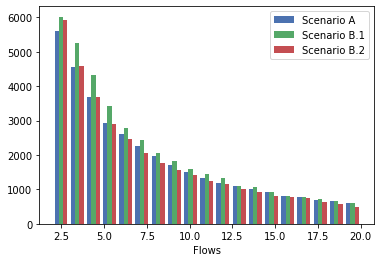

In [62]:
plt.style.use('seaborn-deep')

bins = np.linspace(2, 20, 20)
plt.xlabel('Flows')
plt.hist([ cdatasub['prodsimest4'], cdatasub['unconstrainedEst2'], cdatasub['unconstrainedEst2A']], bins, label=['Scenario A', 'Scenario B.1','Scenario B.2'])
plt.legend(loc='upper right')
plt.show()